In [1]:
import os, sys
import numpy as np
import h5netcdf

import xarray as xr
import xarray.ufuncs as xu
import pandas as pd

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

plt.rc("font", size=14)
ccrs.PlateCarree()

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4)
client = Client(cluster)
client


/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45301 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:45301/status,
Dashboard: http://137.129.155.67:45301/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: inproc://137.129.155.67/33873/1,Workers: 1
Dashboard: http://137.129.155.67:45301/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: inproc://137.129.155.67/33873/4,Total threads: 4
Dashboard: http://137.129.155.67:44249/status,Memory: 78.61 GiB
Nanny: None,


In [2]:
indir_data_FILTERED = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/DISTRIBUTION/'

ds_anom = xr.open_mfdataset(indir_data_FILTERED + 'distribution_OLR_ano.nc')

ds = xr.open_mfdataset(indir_data_FILTERED + 'distribution_OLR_MJO.nc')
da_EIG = xr.open_mfdataset(indir_data_FILTERED + 'distribution_OLR_EIG.nc')
da_WIG = xr.open_mfdataset(indir_data_FILTERED + 'distribution_OLR_WIG.nc')
da_MRG = xr.open_mfdataset(indir_data_FILTERED + 'distribution_OLR_MRG.nc')
da_Kelvin = xr.open_mfdataset(indir_data_FILTERED + 'distribution_OLR_Kelvin.nc')
da_Rossby = xr.open_mfdataset(indir_data_FILTERED + 'distribution_OLR_Rossby.nc')
da_TD = xr.open_mfdataset(indir_data_FILTERED + 'distribution_OLR_TD.nc')

ds['OLR_EIG'] = da_EIG['OLR_EIG']
ds['OLR_WIG'] = da_WIG['OLR_WIG']
ds['OLR_MRG'] = da_MRG['OLR_MRG']
ds['OLR_Kelvin'] = da_Kelvin['OLR_Kelvin']
ds['OLR_Rossby'] = da_Rossby['OLR_Rossby']
ds['OLR_TD'] = da_TD['OLR_TD']

# ds = ds.squeeze('variable')
ds

<xarray.Dataset>
Dimensions:     (nRange: 301, lat: 60, lon: 360)
Coordinates:
  * nRange      (nRange) float64 -150.0 -149.0 -148.0 ... 148.0 149.0 150.0
    time        datetime64[ns] ...
  * lat         (lat) float32 -29.5 -28.5 -27.5 -26.5 ... 26.5 27.5 28.5 29.5
  * lon         (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    OLR_MJO     (nRange, lat, lon) float64 dask.array<chunksize=(301, 60, 360), meta=np.ndarray>
    OLR_EIG     (nRange, lat, lon) float64 dask.array<chunksize=(301, 60, 360), meta=np.ndarray>
    OLR_WIG     (nRange, lat, lon) float64 dask.array<chunksize=(301, 60, 360), meta=np.ndarray>
    OLR_MRG     (nRange, lat, lon) float64 dask.array<chunksize=(301, 60, 360), meta=np.ndarray>
    OLR_Kelvin  (nRange, lat, lon) float64 dask.array<chunksize=(301, 60, 360), meta=np.ndarray>
    OLR_Rossby  (nRange, lat, lon) float64 dask.array<chunksize=(301, 60, 360), meta=np.ndarray>
    OLR_TD      (nRange, lat, lon) float64 dask.array<chunksize=(301, 60, 360), meta=np.ndarray>

In [3]:
_ds = ds.sum(dim = ['lat','lon']).compute()
_ds = _ds.sel(nRange = slice(-30,30))

_ds_anom = ds_anom.sum(dim = ['lat','lon']).compute()
_ds_anom = _ds_anom.sel(nRange = slice(-100,100))

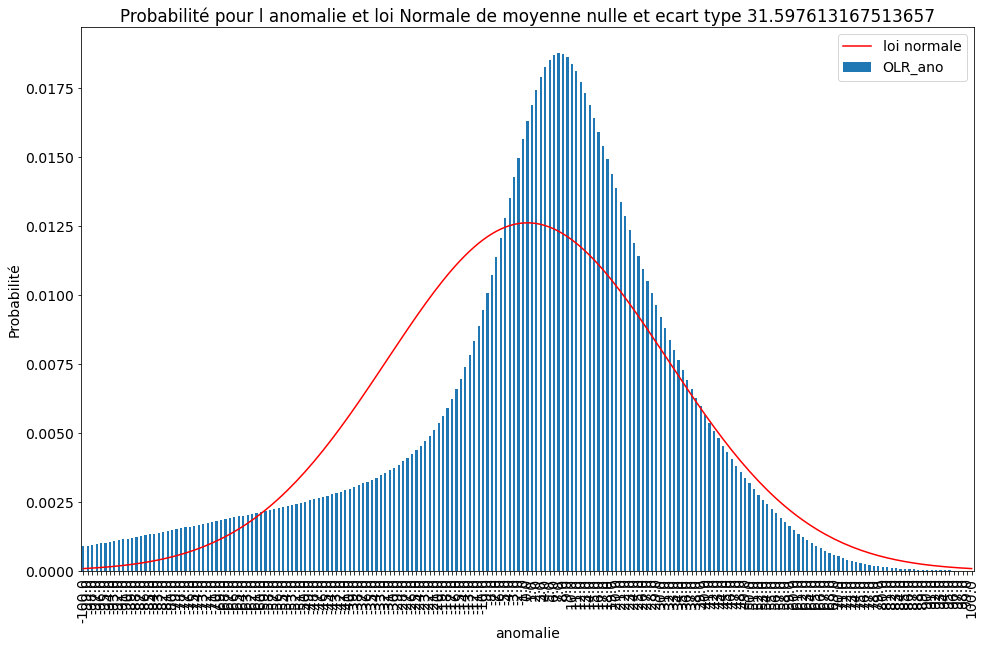

In [5]:
plt.rc("figure", figsize=(16,10))

da = _ds_anom['OLR_ano']


Somme = 0
for i in range(da.nRange.size):
    Somme = Somme + int(da.isel(nRange = i).values)
    
Prob = da/Somme

ecart_type = 0
for i in range(da.nRange.size):
    ecart_type = ecart_type + Prob.isel(nRange = i).values * (int(da.nRange[i].values))**2
    
ecart_type = np.sqrt(ecart_type)
fGauss = 1 / (ecart_type * np.sqrt(2 * np.pi)) * np.exp( -0.5 * (da.nRange.values/ecart_type)**2) 
_da = xr.DataArray(
    data=fGauss,
    dims=["nRange"],
    coords=dict(
        nRange=(["nRange"], da.nRange.data + int(da.nRange.size/2))
    )
)



rain_series = Prob.to_series()

#########################################""
ax = rain_series.plot.bar()
# plt.axvline(x = 30, color = 'black' )
_da.plot(color = 'red', label = 'loi normale')
plt.xlabel('anomalie')
plt.ylabel('Probabilité')
plt.title('Probabilité pour l anomalie et loi Normale de moyenne nulle et ecart type '+ str((ecart_type)))
plt.legend()
plt.show()

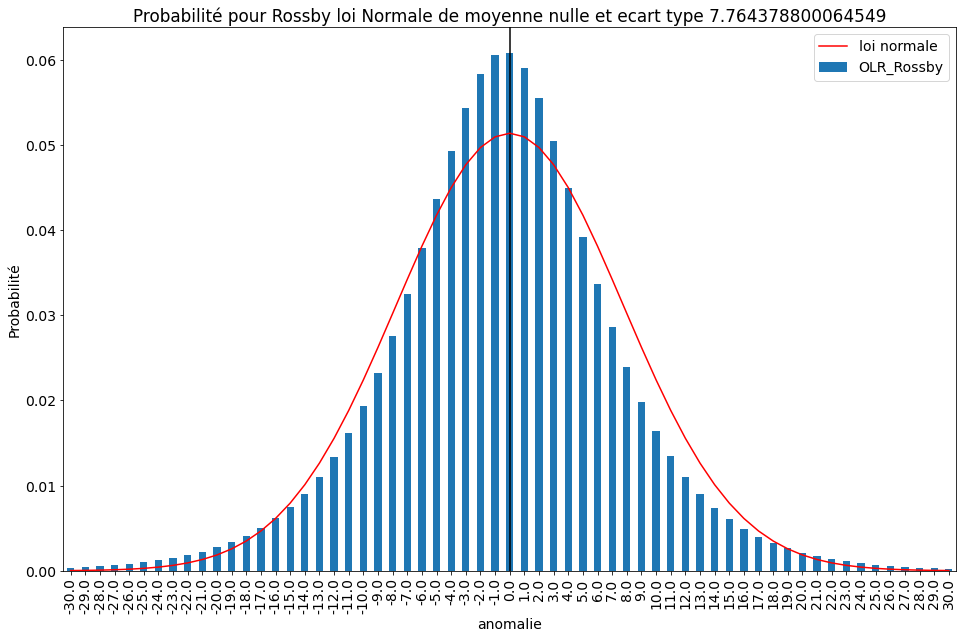

In [6]:
plt.rc("figure", figsize=(16,10))

wave = 'Rossby'
da = _ds['OLR_' + wave]


Somme = 0
for i in range(da.nRange.size):
    Somme = Somme + int(da.isel(nRange = i).values)
    
Prob = da/Somme

ecart_type = 0
for i in range(_ds.nRange.size):
    ecart_type = ecart_type + da.isel(nRange = i).values * (int(_ds.nRange[i].values))**2
    
ecart_type = np.sqrt(ecart_type/Somme)
fGauss = 1 / (ecart_type * np.sqrt(2 * np.pi)) * np.exp( -0.5 * (_ds.nRange.values/ecart_type)**2) 
_da = xr.DataArray(
    data=fGauss,
    dims=["nRange"],
    coords=dict(
        nRange=(["nRange"], da.nRange.data + int(da.nRange.size/2))
    )
)



rain_series = Prob.to_series()

#########################################""
ax = rain_series.plot.bar()
plt.axvline(x = int(da.nRange.size/2), color = 'black' )
_da.plot(color = 'red', label = 'loi normale')
plt.xlabel('anomalie')
plt.ylabel('Probabilité')
plt.title('Probabilité pour ' + wave + ' loi Normale de moyenne nulle et ecart type '+ str((ecart_type)))
plt.legend()
plt.show()

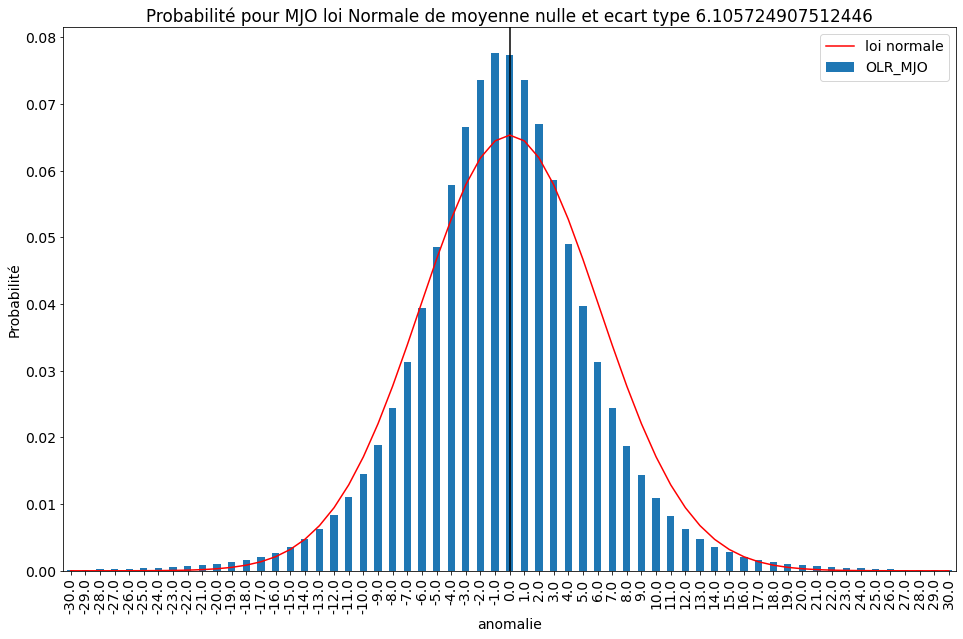

In [7]:
wave = 'MJO'
da = _ds['OLR_' + wave]


Somme = 0
for i in range(da.nRange.size):
    Somme = Somme + int(da.isel(nRange = i).values)
    
Prob = da/Somme

ecart_type = 0
for i in range(_ds.nRange.size):
    ecart_type = ecart_type + da.isel(nRange = i).values * (int(_ds.nRange[i].values))**2
    
ecart_type = np.sqrt(ecart_type/Somme)
fGauss = 1 / (ecart_type * np.sqrt(2 * np.pi)) * np.exp( -0.5 * (_ds.nRange.values/ecart_type)**2) 
_da = xr.DataArray(
    data=fGauss,
    dims=["nRange"],
    coords=dict(
        nRange=(["nRange"], da.nRange.data + int(da.nRange.size/2))
    )
)



rain_series = Prob.to_series()

#########################################""
ax = rain_series.plot.bar()
plt.axvline(x = int(da.nRange.size/2), color = 'black' )
_da.plot(color = 'red', label = 'loi normale')
plt.xlabel('anomalie')
plt.ylabel('Probabilité')
plt.title('Probabilité pour ' + wave + ' loi Normale de moyenne nulle et ecart type '+ str((ecart_type)))
plt.legend()
plt.show()

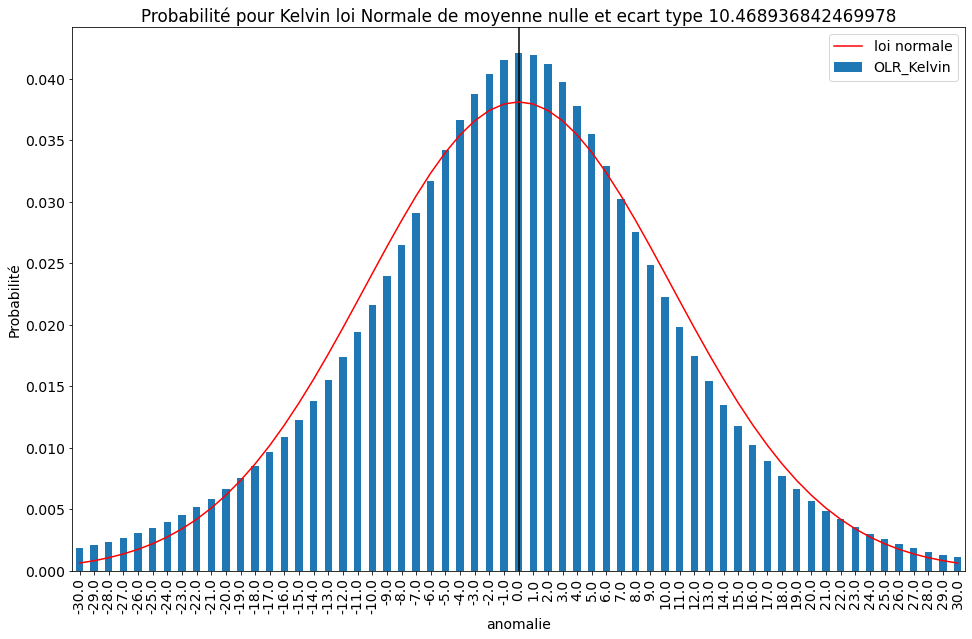

In [8]:
wave = 'Kelvin'
da = _ds['OLR_' + wave]

Somme = 0
for i in range(da.nRange.size):
    Somme = Somme + int(da.isel(nRange = i).values)
    
Prob = da/Somme

ecart_type = 0
for i in range(_ds.nRange.size):
    ecart_type = ecart_type + da.isel(nRange = i).values * (int(_ds.nRange[i].values))**2
    
ecart_type = np.sqrt(ecart_type/Somme)
fGauss = 1 / (ecart_type * np.sqrt(2 * np.pi)) * np.exp( -0.5 * (_ds.nRange.values/ecart_type)**2) 
_da = xr.DataArray(
    data=fGauss,
    dims=["nRange"],
    coords=dict(
        nRange=(["nRange"], da.nRange.data + int(da.nRange.size/2))
    )
)



rain_series = Prob.to_series()

#########################################""
ax = rain_series.plot.bar()
plt.axvline(x = int(da.nRange.size/2), color = 'black' )
_da.plot(color = 'red', label = 'loi normale')
plt.xlabel('anomalie')
plt.ylabel('Probabilité')
plt.title('Probabilité pour ' + wave + ' loi Normale de moyenne nulle et ecart type '+ str((ecart_type)))
plt.legend()
plt.show()

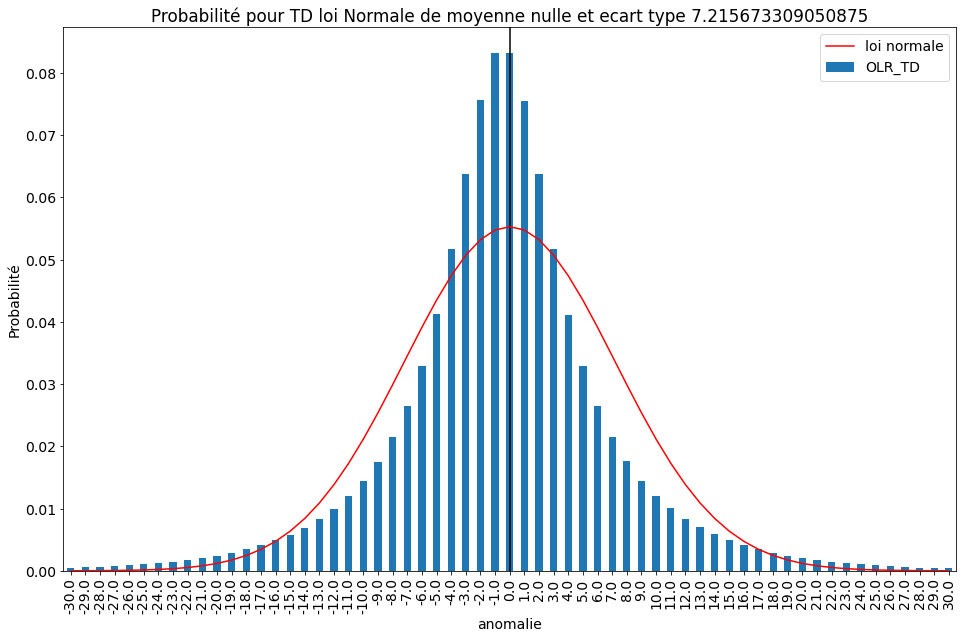

In [9]:
wave = 'TD'
da = _ds['OLR_' + wave]


Somme = 0
for i in range(da.nRange.size):
    Somme = Somme + int(da.isel(nRange = i).values)
    
Prob = da/Somme

ecart_type = 0
for i in range(_ds.nRange.size):
    ecart_type = ecart_type + da.isel(nRange = i).values * (int(_ds.nRange[i].values))**2
    
ecart_type = np.sqrt(ecart_type/Somme)
fGauss = 1 / (ecart_type * np.sqrt(2 * np.pi)) * np.exp( -0.5 * (_ds.nRange.values/ecart_type)**2) 
_da = xr.DataArray(
    data=fGauss,
    dims=["nRange"],
    coords=dict(
        nRange=(["nRange"], da.nRange.data + int(da.nRange.size/2))
    )
)



rain_series = Prob.to_series()

#########################################""
ax = rain_series.plot.bar()
plt.axvline(x = int(da.nRange.size/2), color = 'black' )
_da.plot(color = 'red', label = 'loi normale')
plt.xlabel('anomalie')
plt.ylabel('Probabilité')
plt.title('Probabilité pour ' + wave + ' loi Normale de moyenne nulle et ecart type '+ str((ecart_type)))
plt.legend()
plt.show()

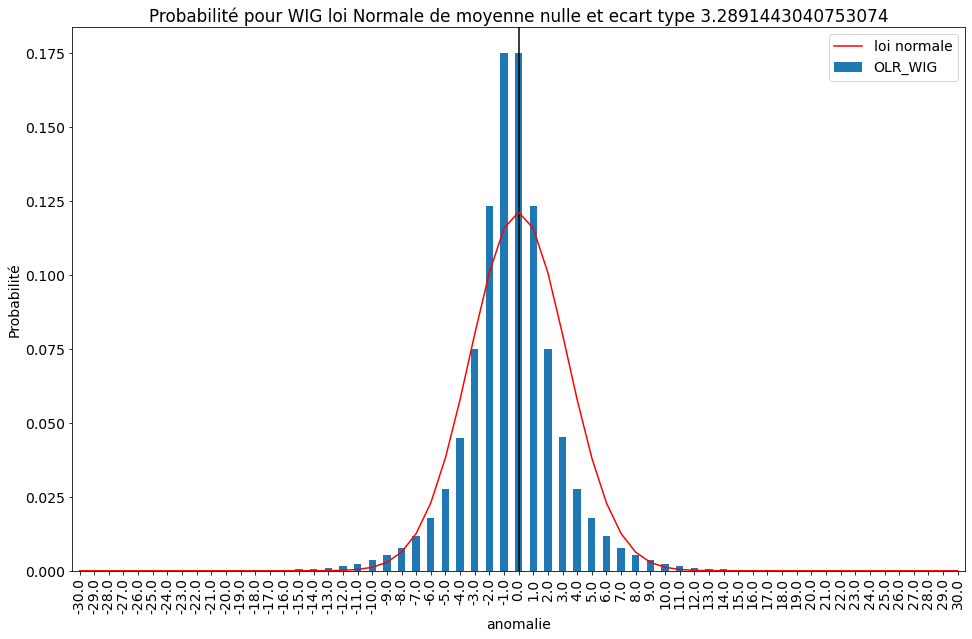

In [10]:
wave = 'WIG'
da = _ds['OLR_' + wave]


Somme = 0
for i in range(da.nRange.size):
    Somme = Somme + int(da.isel(nRange = i).values)
    
Prob = da/Somme

ecart_type = 0
for i in range(_ds.nRange.size):
    ecart_type = ecart_type + da.isel(nRange = i).values * (int(_ds.nRange[i].values))**2
    
ecart_type = np.sqrt(ecart_type/Somme)
fGauss = 1 / (ecart_type * np.sqrt(2 * np.pi)) * np.exp( -0.5 * (_ds.nRange.values/ecart_type)**2) 
_da = xr.DataArray(
    data=fGauss,
    dims=["nRange"],
    coords=dict(
        nRange=(["nRange"], da.nRange.data + int(da.nRange.size/2))
    )
)



rain_series = Prob.to_series()

#########################################""
ax = rain_series.plot.bar()
plt.axvline(x = int(da.nRange.size/2), color = 'black' )
_da.plot(color = 'red', label = 'loi normale')
plt.xlabel('anomalie')
plt.ylabel('Probabilité')
plt.title('Probabilité pour ' + wave + ' loi Normale de moyenne nulle et ecart type '+ str((ecart_type)))
plt.legend()
plt.show()

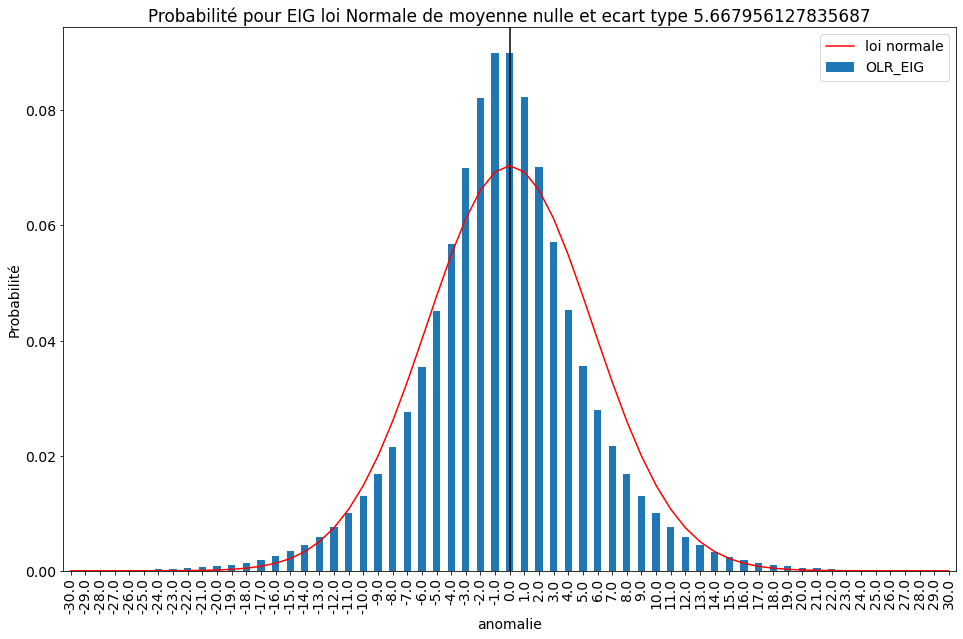

In [11]:
plt.rc("figure", figsize=(16,10))

wave = 'EIG'
da = _ds['OLR_' + wave]

Somme = 0
for i in range(da.nRange.size):
    Somme = Somme + int(da.isel(nRange = i).values)
    
Prob = da/Somme

ecart_type = 0
for i in range(_ds.nRange.size):
    ecart_type = ecart_type + da.isel(nRange = i).values * (int(_ds.nRange[i].values))**2
    
ecart_type = np.sqrt(ecart_type/Somme)
fGauss = 1 / (ecart_type * np.sqrt(2 * np.pi)) * np.exp( -0.5 * (_ds.nRange.values/ecart_type)**2) 
_da = xr.DataArray(
    data=fGauss,
    dims=["nRange"],
    coords=dict(
        nRange=(["nRange"], da.nRange.data + int(da.nRange.size/2))
    )
)



rain_series = Prob.to_series()

#########################################""
ax = rain_series.plot.bar()
plt.axvline(x = int(da.nRange.size/2), color = 'black' )
_da.plot(color = 'red', label = 'loi normale')
plt.xlabel('anomalie')
plt.ylabel('Probabilité')
plt.title('Probabilité pour ' + wave + ' loi Normale de moyenne nulle et ecart type '+ str((ecart_type)))
plt.legend()
plt.show()

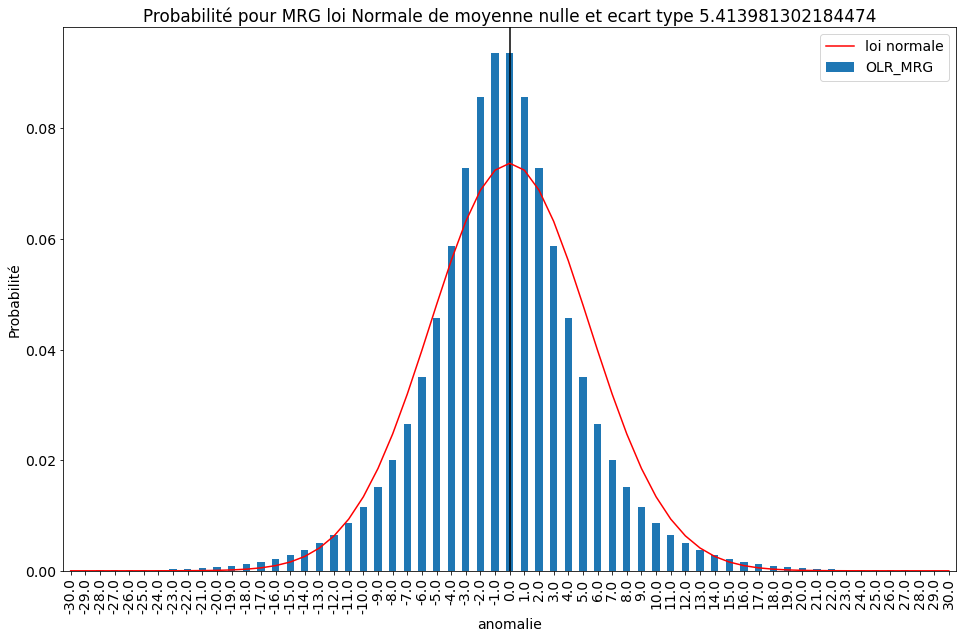

In [12]:
plt.rc("figure", figsize=(16,10))

wave = 'MRG'
da = _ds['OLR_' + wave]

Somme = 0
for i in range(da.nRange.size):
    Somme = Somme + int(da.isel(nRange = i).values)
    
Prob = da/Somme

ecart_type = 0
for i in range(_ds.nRange.size):
    ecart_type = ecart_type + da.isel(nRange = i).values * (int(_ds.nRange[i].values))**2
    
ecart_type = np.sqrt(ecart_type/Somme)
fGauss = 1 / (ecart_type * np.sqrt(2 * np.pi)) * np.exp( -0.5 * (_ds.nRange.values/ecart_type)**2) 
_da = xr.DataArray(
    data=fGauss,
    dims=["nRange"],
    coords=dict(
        nRange=(["nRange"], da.nRange.data + int(da.nRange.size/2))
    )
)



rain_series = Prob.to_series()

#########################################""
ax = rain_series.plot.bar()
plt.axvline(x = int(da.nRange.size/2), color = 'black' )
_da.plot(color = 'red', label = 'loi normale')
plt.xlabel('anomalie')
plt.ylabel('Probabilité')
plt.title('Probabilité pour ' + wave + ' loi Normale de moyenne nulle et ecart type '+ str((ecart_type)))
plt.legend()
plt.show()